In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import csv
from collections import defaultdict
from utils.gini import gini

In [2]:
post_feature_table = open('output/reddit_submissions_basic_features_nodelete_jan2012.tsv')
reader = csv.DictReader(post_feature_table, delimiter='\t')
days = {d: i for (i, d) in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])}
hours = range(24)

In [3]:
# List of post scores per username.
user_scores = defaultdict(list)
# List of post scores per hour of day. Hour 0 starts at midnight on Monday ET
hour_scores = [[] for _ in range(len(days)*len(hours))] 

cum_post_scores = []
cum_mean_post_scores = []
# cum_com_scores = []
scores = []

for (i, row) in enumerate(reader):
    # Update scorelist for author
    score = int(row['Score'])
    author = row['Author']
    
    if author != '[deleted]':
        cpsc = int(row['Author_Cum_Post_Score'])
        cp = int(row['Author_Cum_Posts'])
        
        if cp > 0:
            user_scores[author].append(score)
            cum_post_scores.append(cpsc)
            cum_mean_post_scores.append(float(cpsc)/cp)
            scores.append(score)
    
    # Update scorelist for hour of the week
    daystr = [d for d in days if row['Is_US_Eastern_' + d] == '1'][0]
    daynum = days[daystr]
    day_hournum = [h for h in hours if row['Is_US_Eastern_Hour_{}'.format(h)] == '1'][0]
    week_hournum = 24 * daynum + day_hournum
    hour_scores[week_hournum].append(score)

    if i % 100000 == 0:
        print('{} posts parsed'.format(i))
        
print('Done')

0 posts parsed
100000 posts parsed
200000 posts parsed
300000 posts parsed
400000 posts parsed
500000 posts parsed
600000 posts parsed
700000 posts parsed
800000 posts parsed
900000 posts parsed
Done


In [4]:
# Different times of the week show better post reception
hourmeans = [np.mean(l) for l in hour_scores]

# Create smoothed version
window = 6
hourmeans_wrap = hourmeans[-window/2:] + hourmeans + hourmeans[:window/2]
hourmeans_smoothed = [np.mean(hourmeans_wrap[i-window/2:i+window/2+1])
                      for i in range(window/2, len(hourmeans)+window/2)]

# Plot 
plt.figure()
plt.plot(range(len(hourmeans)), hourmeans, label='raw', color=(0.7,0.7,0.7), linestyle='dashed')
plt.plot(range(len(hourmeans)), hourmeans_smoothed, color='r', label='smoothed')
plt.xlim((0, len(hours)*len(days)-1))
plt.ylim((0, 1.1*np.max(hourmeans)))
plt.xticks(range(0, (len(days)+1)*len(hours), len(hours)))
plt.xlabel('Hour of week')
plt.ylabel('Mean post score')
plt.legend()
plt.title('Mean post score throughout the week')

for d in days:
    pos = len(hours) * (days[d] + 1.0/2.2)
    plt.text(pos, 1, d[0])
    
plt.savefig('plots/post_trends.eps', format='eps', dpi=1000)

In [5]:
# Info about user activity
userscore_means = sorted((np.mean(l) for l in user_scores.values()), reverse=True)
userscore_sums = sorted((np.sum(l) for l in user_scores.values()), reverse=True)
user_postnums = sorted((len(l) for l in user_scores.values()), reverse=True)

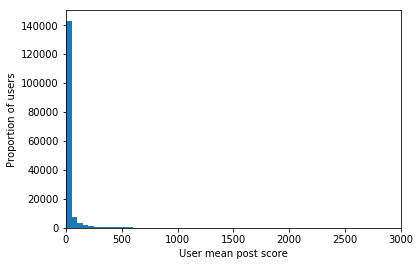

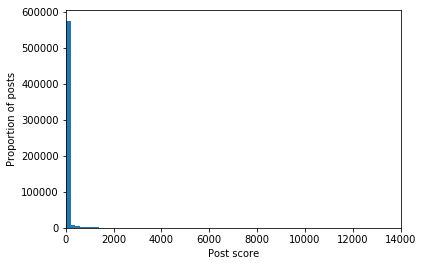

In [25]:
# User scores are strongly skewed towards a very low range
plt.figure()
plt.hist(userscore_means, density=False, bins=np.arange(0, 3000, 50))
plt.xlim((0,3000))
plt.xlabel('User mean post score')
plt.ylabel('Proportion of users')
plt.show()

# As are all post scores
allscores = []
for user in user_scores:
    allscores.extend(user_scores[user])

plt.figure()
plt.hist(allscores, bins=np.arange(0, 14000, 200))
plt.xlim((0,14000))
plt.xlabel('Post score')
plt.ylabel('Proportion of posts')
plt.show()

In [7]:
# Most active users are much more active than others

plt.figure()
plt.semilogy(range(len(userscore_means)), userscore_means, color='r', label='mean post score')
plt.semilogy(range(len(userscore_sums)), userscore_sums, color=(0.96, 0.5, 0.25), label='total post score')
plt.semilogy(range(len(user_postnums)), user_postnums, color=(0,0.5,1), label='number of posts')

plt.xlim((0,150000))
plt.ylim((1e-1, 1e5))
plt.legend()
plt.xlabel('User rank')
plt.ylabel('log(metric)')
plt.title('Users, great and small')
plt.savefig('plots/power_users.eps', dpi=1000, format='eps')

In [8]:
# Lorenz curves for total numbers of posts and total post scores show large inequity
def to_lorenz(array):
    result = np.array(sorted(array), dtype=np.float64)
    result = np.cumsum(result)
    result /= result[-1]
    return result

lorenz_means = to_lorenz(userscore_means)
lorenz_sums = to_lorenz(userscore_sums)
lorenz_nums = to_lorenz(user_postnums)

plt.figure()
#plt.plot(np.linspace(0, 1, len(lorenz_means)), lorenz_means, label='mean post score')
plt.plot(np.linspace(0, 1, len(lorenz_sums)), lorenz_sums, color='#FF8b60', label='total post score')
plt.plot(np.linspace(0, 1, len(lorenz_nums)), lorenz_nums, color='#9494FF', label='number of posts')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('Fraction of users')
plt.title('User Lorenz curves')
plt.legend()
plt.savefig('plots/user_lorenz.eps', dpi=1000, format='eps')

print(gini(np.array(user_postnums, dtype=np.float64)))
print(gini(np.array(userscore_sums, dtype=np.float64)))

0.543092312899
0.881995388394


In [9]:
# User score totals are highly correlated with number of posts made
plt.figure()
plt.scatter(user_postnums, userscore_sums, s=10, color='#FF8b60')
plt.xlabel('Number of posts')
plt.ylabel('Total score')
plt.xlim((0,2750)); plt.ylim((0,110000))
plt.title('User totals and post activity')
plt.savefig('plots/score_vs_sums.png', format='png', dpi=1000)

print(scipy.stats.pearsonr(user_postnums, userscore_sums)[0]**2)

0.923241376535


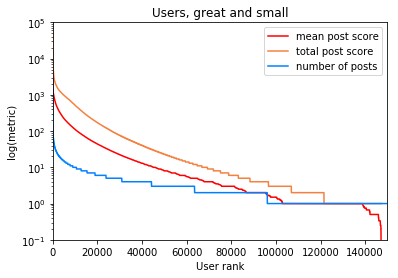

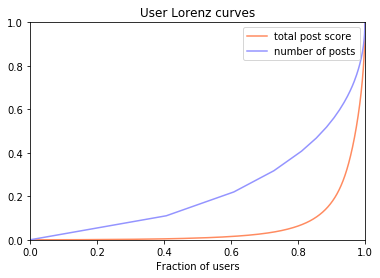

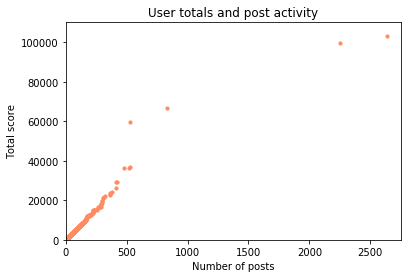

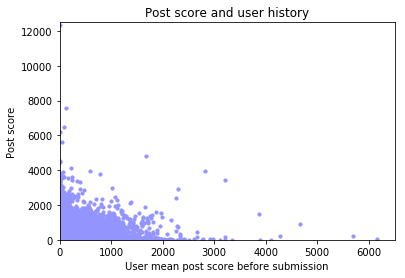

Pearson correlation: 0.0204446875815


In [10]:
plt.figure()
plt.scatter(cum_mean_post_scores, scores, s=10, color='#9494FF')
plt.xlim((0,6500))
plt.ylim((0,12500))
plt.xlabel('User mean post score before submission')
plt.ylabel('Post score')
plt.title('Post score and user history')
plt.savefig('plots/post_score_history.png', format='png', dpi=1000)
plt.show()

print('Pearson correlation: {}'.format(scipy.stats.pearsonr(cum_mean_post_scores, scores)[0]**2))